In [108]:
#importing libraries 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.metrics import *
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img

# For Data Processing
import numpy as np

# For Data Visualization
import matplotlib.pyplot as plt

# Miscellaneous
import os
import random

# Turn off warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# <b> <span style='color:#FFDB00; font-weight: bold;'>|</span> Variables & Functions</b>

In [109]:
TRAIN_SIZE = 384
INFERENCE_SIZE = 224

<h2><span style='color:#FFDB00; font-weight: bold;'>|</span> Train-Test Split</h2>  

In [110]:
main_dir = '/kaggle/input/div2k-dataset/DIV2K_train_HR/DIV2K_train_HR/'
all_image_paths = [main_dir+file for file in os.listdir(main_dir) if file.endswith('.png')]

print('Total number of images:', len(all_image_paths))

Total number of images: 800


In [112]:
len(all_image_paths)

800

In [113]:
train_image_paths = all_image_paths[:600]
test_image_paths = all_image_paths[600:]

In [114]:
len(train_image_paths)

600

In [115]:
len(test_image_paths)

200

<h2><span style='color:#FFDB00; font-weight: bold;'>|</span> Function to open images</h2>  

In [116]:
def open_images(paths, size=TRAIN_SIZE):
    '''
    Given an array of paths to images, this function opens those images,
    and returns them as an array of shape (None, Height, Width, Channels)
    '''
    images = []
    for path in paths:
        image = load_img(path, target_size=(size, size, 3))
        image = np.array(image)/255.0 # Normalize image pixel values to be between 0 and 1
        images.append(image)
    return np.array(images)

<h2><span style='color:#FFDB00; font-weight: bold;'>|</span> Function to add noise</h2>  

In [117]:
def add_noise(images, amount=0.1):
    '''
    Given an array of images [a shape of (None, Height, Width, Channels)],
    this function adds gaussian noise to every channel of the images
    '''
    # Create a matrix with values with a mean of 0 and standard deviation of "amount"
    noise = np.random.normal(0, amount, images.shape[0]*images.shape[1]*images.shape[2]*images.shape[3]).reshape(images.shape)
    # Add noise to images
    noise_img = images+noise
    return noise_img

In [118]:
open_images([train_image_paths[2]])

array([[[[0.38823529, 0.33333333, 0.25882353],
         [0.38039216, 0.3254902 , 0.27058824],
         [0.38039216, 0.3372549 , 0.2627451 ],
         ...,
         [0.41568627, 0.33333333, 0.29411765],
         [0.40784314, 0.35686275, 0.29019608],
         [0.41176471, 0.34509804, 0.30980392]],

        [[0.41960784, 0.36470588, 0.26666667],
         [0.40784314, 0.34901961, 0.28235294],
         [0.32941176, 0.30980392, 0.23529412],
         ...,
         [0.43137255, 0.35686275, 0.29803922],
         [0.38823529, 0.34901961, 0.30588235],
         [0.29803922, 0.26666667, 0.21568627]],

        [[0.1254902 , 0.09803922, 0.07058824],
         [0.10196078, 0.0745098 , 0.05882353],
         [0.09803922, 0.07058824, 0.03921569],
         ...,
         [0.4       , 0.33333333, 0.30588235],
         [0.35294118, 0.29411765, 0.25490196],
         [0.05490196, 0.04313725, 0.05490196]],

        ...,

        [[0.1254902 , 0.12156863, 0.1254902 ],
         [0.13333333, 0.13333333, 0.12941176]

Example usage of functions `open_images` and `add_noise` :

In [119]:
image = open_images([train_image_paths[27]])

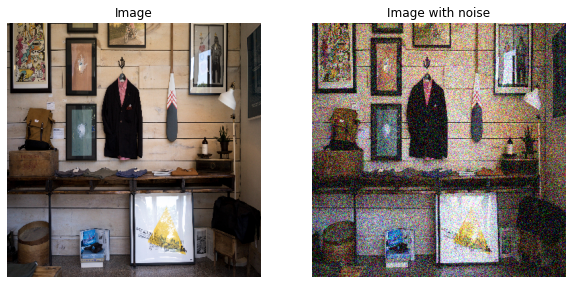

In [120]:
image = open_images([train_image_paths[2]])
noise_img = add_noise(image, amount=0.2)

fig = plt.figure(figsize=(10, 5))
# Plot Image
fig.add_subplot(1, 2, 1)
plt.axis('off')
plt.title('Image')
plt.imshow(image[0])
# Plot Image with noise
fig.add_subplot(1, 2, 2)
plt.axis('off')
plt.title('Image with noise')
plt.imshow(noise_img[0])

plt.show()

# <b>1 <span style='color:#FFDB00; font-weight: bold;'>|</span> Data Generator</b>

This generator function returns batches on which the neural network can train on

In [121]:
def datagen(paths, size=TRAIN_SIZE, batch_size=5):
    '''
    Given an array of images to paths,
    this function returns batch of images as (noise_image, real_image)
    '''
    for x in range(0, len(paths), batch_size):
        batch_paths = paths[x:x+batch_size]
        batch_images = open_images(batch_paths, size=size)
        amount = random.uniform(0,0.2) # Amount of noise = random value between 0 and 0.2
        noise_images = add_noise(batch_images, amount=amount)
        yield noise_images, batch_images

<h2>2 <span style='color:#FFDB00; font-weight: bold;'>|</span> Build Model</h2>  

The neural network is fully convolutional, so it can be applied on images of any shapes.  
To make the model accept variable size inputs, we set the input shape parameter to `(None, None, 3)`

In [127]:
image = Input(shape=(None,None,3))

# Encoder
l1 = Conv2D(32, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(image)     
l2 = Conv2D(32, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l1)

l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l4)

l6 = MaxPooling2D(padding='same')(l5)
l7 = Conv2D(128, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l6)

#Decoder
l8 = UpSampling2D()(l7)
l9 = Conv2D(64, (3,3), padding='same', activation='relu',
           activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(64, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5,l10])
l12 = UpSampling2D()(l11)
l13 = Conv2D(32, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(32, (3,3), padding='same', activation='relu',
            activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14,l2])

decoded = Conv2D(3, (3,3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l15)
model = Model(image, decoded)

In [128]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_44 (Conv2D)              (None, None, None, 3 896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, None, None, 3 9248        conv2d_44[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, None, None, 3 0           conv2d_45[0][0]                  
____________________________________________________________________________________________

<h2>3 <span style='color:#FFDB00; font-weight: bold;'>|</span> Compile Model</h2>  

In [132]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
             loss='binary_crossentropy')

<h2>4 <span style='color:#FFDB00; font-weight: bold;'>|</span> Train Model</h2>  

Train model on images of shape `TRAIN_SIZE`, and a batch size of 10

In [138]:
batch_size=10
steps = int(len(train_image_paths)/batch_size)
epochs = 10
for epoch in range(epochs):
    model.fit(datagen(train_image_paths, size=TRAIN_SIZE, batch_size=batch_size), epochs=1, steps_per_epoch=steps)

60/60 [==============================] - 84s 1s/step - loss: 0.5143


<h2>5 <span style='color:#FFDB00; font-weight: bold;'>|</span> Evaluate Model</h2>  

Evaluate the model's performance on images of shape `INFERENCE_SIZE`

In [139]:
batch_size=10
steps = int(len(test_image_paths)/batch_size)
model.evaluate(datagen(test_image_paths, size=INFERENCE_SIZE, batch_size=batch_size), steps=steps)

20/20 [==============================] - 22s 1s/step - loss: 0.5218


0.5217546224594116

# <b>6 <span style='color:#FFDB00; font-weight: bold;'>|</span> Result</b>

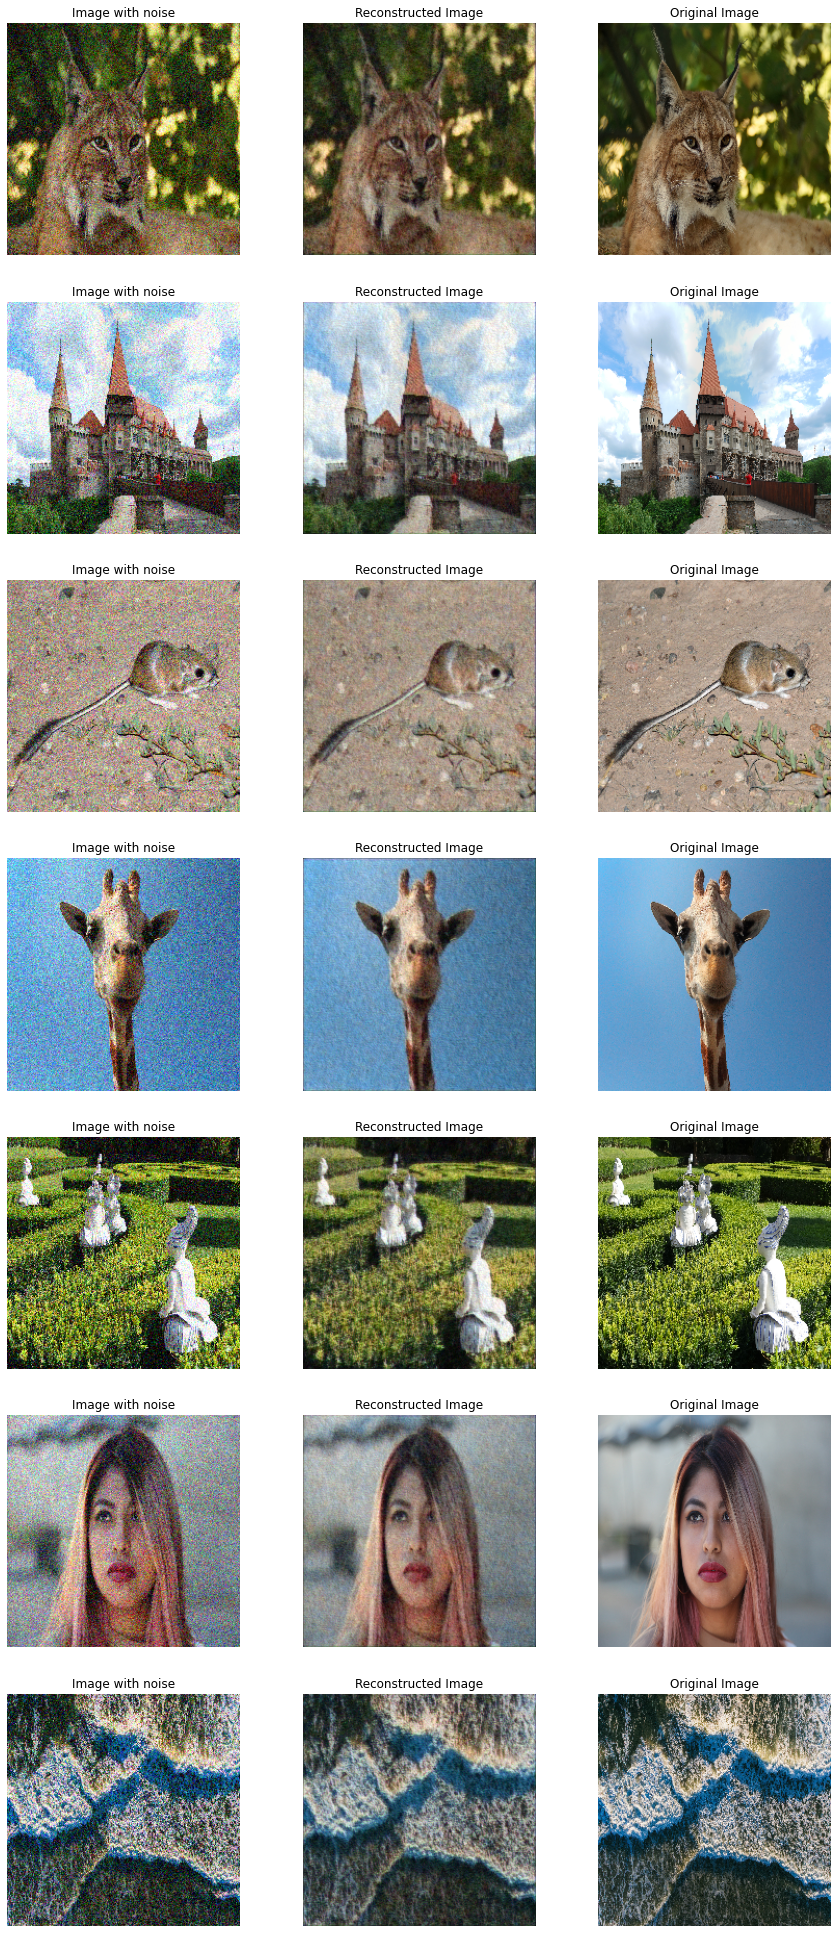

In [140]:
def plot_results(noise_image, reconstructed_image, image):
    w = 15
    h = len(noise_image)*5
    fig = plt.figure(figsize=(w, h))
    columns = 3
    rows = len(noise_image)
    for i in range(1, rows*columns, columns):
        fig.add_subplot(rows, columns, i)
        plt.axis('off')
        plt.title('Image with noise')
        plt.imshow(noise_images[int((i-1)/columns)])
    
        fig.add_subplot(rows, columns, i+1)
        plt.axis('off')
        plt.title('Reconstructed Image')
        plt.imshow(reconstructed[int((i-1)/columns)])
        
        fig.add_subplot(rows, columns, i+2)
        plt.axis('off')
        plt.title('Original Image')
        plt.imshow(images[int((i-1)/columns)])
    
    plt.show()
    
batch_size = 7

paths = random.sample(test_image_paths, batch_size)
images = open_images(paths, size=INFERENCE_SIZE)
# Amount of noise = random value between 0.1 and 0.15
amount = random.uniform(0.1,0.15)
noise_images = add_noise(images, amount=amount)
reconstructed = model.predict(noise_images)

plot_results(noise_images, reconstructed, images)

**test images**

In [218]:
#importing test images
main_dir_upscale = '/kaggle/input/test-data-upscale/'
all_image_paths_upscale = [main_dir_upscale+file for file in os.listdir(main_dir_upscale) if file.endswith('.png')]

print('Total number of images:', len(all_image_paths_upscale))

Total number of images: 6


In [174]:
test_image_upscale = all_image_paths_upscale[:7]

****

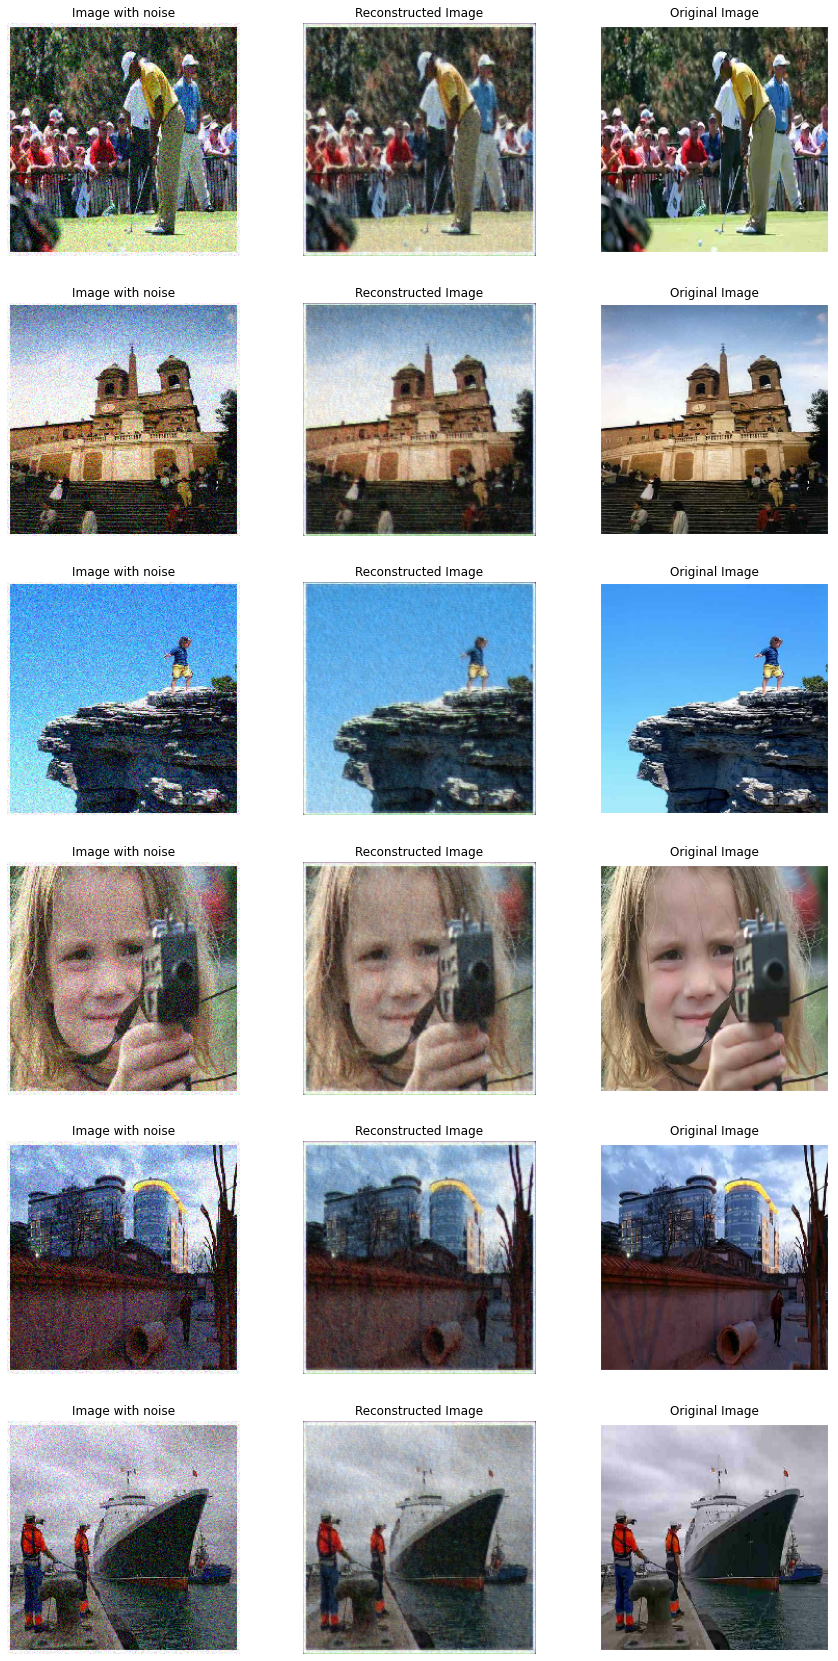

In [176]:
#testing images
batch_size = 6

paths = random.sample(test_image_upscale, batch_size)
images = open_images(paths, size=INFERENCE_SIZE)
# Amount of noise = random value between 0.1 and 0.15
amount = random.uniform(0.1,0.15)
noise_images = add_noise(images, amount=amount)
reconstructed = model.predict(noise_images)

plot_results(noise_images, reconstructed, images)

**saving in zip folder**

In [219]:
import matplotlib.pyplot as plt

# Assuming 'noise_images', 'reconstructed', and 'images' are numpy arrays of images
for i in range(batch_size):
    plt.figure(figsize=(18, 6), dpi=800)  # Increase the figure size and DPI for high resolution

    #plt.subplot(1, 3, 1)
    plt.imshow(images[i])
    plt.title('Original Image')


    # Save the plot as an image file with higher resolution
    plt.savefig(f'/kaggle/working/output_{i}.png')
    plt.close()


In [221]:
import zipfile
import os

# Path to the directory containing the output images
output_directory = '/kaggle/working/'

# List all the image files in the directory
image_files = [f for f in os.listdir(output_directory) if f.startswith('output_') and f.endswith('.png')]

# Path to the zip file
zip_file_path = '/kaggle/working/output_images.zip'

# Create a zip file and add the image files to it
with zipfile.ZipFile(zip_file_path, 'w') as zipf:
    for image_file in image_files:
        zipf.write(os.path.join(output_directory, image_file), image_file)


In [217]:
image_files

['output_2.png',
 'output_4.png',
 'output_0.png',
 'output_5.png',
 'output_1.png',
 'output_3.png']